In [1]:
PIPELINE_CONTEXT = {"_runtime_context_name": "PIPELINE_CONTEXT", "params": {"n_clusters": "auto", "n_clusters_min": 6, "n_clusters_max": 50, "n_clusters_criterion": "silhouette", "pca_components": "auto", "pca_variance": 0.9, "pca_max_components": 50, "random_state": 42}, "artifacts": {"dir": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916", "processed_data": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/processed.parquet", "model_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/kmeans_model.joblib", "scaler_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/scaler.joblib", "pca_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/pca.joblib", "cluster_summary": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/cluster_summary.json", "elbow_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/elbow_plot.png", "silhouette_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/silhouette_plot.png", "db_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/db_plot.png", "ch_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/ch_plot.png", "selection": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/selection.json"}, "cwd": "/Users/savvasneofytou/Desktop/basketball/pipeline", "data_dir": "/Users/savvasneofytou/Desktop/basketball/data/output_by_college_clean"}

**Pipeline Context**

In [2]:
try:
    ctx = PIPELINE_CONTEXT
except NameError:
    import os
    ctx = {
        "params": {},
        "artifacts": {
            "dir": "artifacts",
            "processed_data": "artifacts/processed.parquet",
            "model_file": "artifacts/kmeans_model.joblib",
            "scaler_file": "artifacts/scaler.joblib",
            "pca_file": "artifacts/pca.joblib",
            "cluster_summary": "artifacts/cluster_summary.json",
            "elbow_plot": "artifacts/elbow_plot.png",
            "silhouette_plot": "artifacts/silhouette_plot.png",
            "db_plot": "artifacts/db_plot.png",
            "ch_plot": "artifacts/ch_plot.png",
            "selection": "artifacts/selection.json",
        },
        "data_dir": "data",
    }

from pathlib import Path
import json

P = ctx.get("params", {})
PATHS = ctx.get("artifacts", {})
DATA_DIR = ctx.get("data_dir", "data")
Path(PATHS["dir"]).mkdir(parents=True, exist_ok=True)

def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=float)

def load_json(path, default=None):
    p = Path(path)
    if p.exists():
        return json.loads(p.read_text())
    return {} if default is None else default


**Imports**


In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm
import joblib
import json

/Users/savvasneofytou/Desktop/basketball/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Loading**

In [4]:
df_pca = pd.read_csv('df_pca.csv', index_col=0)
print("df_pca shape:", df_pca.shape)

df_full = pd.read_csv('player_features_cleaned.csv')
print("player_features_cleaned shape:", df_full.shape)

df_clean = pd.read_csv('df_clean.csv')
print("df_clean shape:", df_clean.shape)

df_pca shape: (1199, 13)
player_features_cleaned shape: (2095, 81)
df_clean shape: (1199, 81)


In [5]:
print(df_full['player_id'])

0        11
1         0
2         8
3         9
4         1
       ... 
2090    833
2091    720
2092    309
2093    681
2094    199
Name: player_id, Length: 2095, dtype: int64


In [6]:
print("df_pca head:")
print(df_pca.head())

df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  4.894828 -6.021775  1.175605  1.828027  1.254419 -1.698196 -0.747838   
1  2.695309  3.455515  3.928776  0.342063 -0.936057  0.428470  0.103474   
2  4.274359  0.167899 -0.198460  2.382171  2.688934  0.968804  0.628713   
3  2.391123  1.892141  1.478541 -1.920558 -1.240439 -0.439641 -0.058615   
4  3.294844 -1.436508 -2.265885  3.622604  0.880100  1.750835  3.158057   

        PC8       PC9      PC10 player_number_ind player_ind  player_id  
0  0.149324  2.698441  0.031510          Fournier       Toby         11  
1 -1.255971  2.200846  0.489902           Jackson     Ashlon          0  
2 -0.124098  2.404724 -1.539147          Okananwa     Oluchi          8  
3 -1.267509  2.601706  0.449648        Richardson     Reigan          9  
4 -1.439421  2.316716 -0.246851            Thomas    Delaney          1  


In [7]:
# pull the PC columns into a NumPy array
pc_cols   = [c for c in df_pca.columns if c.startswith('PC')]
X_cluster = df_pca[pc_cols].values


In [8]:
print(df_clean.columns)

Index(['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind',
       'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind',
       'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40',
       'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct',
       'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO',
       '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100',
       'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR',
       'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC',
       'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM',
       'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions',
       'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100',
       'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game',
       'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game',
       'to_per_game', 'scoring_pts_share', 'ast_share

**K-MEANS CLUSTERING**



In [9]:
# K-Means Elbow, Silhouette, Davies–Bouldin & Calinski–Harabasz Sweep

ks = list(range(6, 30))    
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_cluster)
    
    # Inertia
    inertias.append(km.inertia_)
    
    # Guards for metrics that require at least 2 non-empty clusters
    if len(np.unique(labels_k)) > 1:
        sil = silhouette_score(X_cluster, labels_k)
        db  = davies_bouldin_score(X_cluster, labels_k)
        ch  = calinski_harabasz_score(X_cluster, labels_k)
    else:
        sil, db, ch = np.nan, np.nan, np.nan
    
    sil_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

# Elbow plot (save)
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("K-Means Elbow")
plt.tight_layout()
plt.savefig(PATHS["elbow_plot"], dpi=144)
plt.close()

# Silhouette plot (save)
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("K-Means Silhouette vs. k")
plt.tight_layout()
plt.savefig(PATHS["silhouette_plot"], dpi=144)
plt.close()

# Davies–Bouldin plot (save) - lower is better
plt.figure(figsize=(6,4))
plt.plot(ks, db_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Davies–Bouldin Index (↓)")
plt.title("Davies–Bouldin vs. k")
plt.tight_layout()
plt.savefig(PATHS["db_plot"], dpi=144)
plt.close()

# Calinski–Harabasz plot (save) - higher is better
plt.figure(figsize=(6,4))
plt.plot(ks, ch_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Calinski–Harabasz (↑)")
plt.title("Calinski–Harabasz vs. k")
plt.tight_layout()
plt.savefig(PATHS["ch_plot"], dpi=144)
plt.close()

# Choose best_k by silhouette
best_k = ks[int(np.nanargmax(sil_scores))]
print(f"Best k by silhouette score: {best_k} with score {np.nanmax(sil_scores):.4f}")

# Persist selection and (optionally) metric snapshots
selected = load_json(PATHS["selection"], default={})
selected["best_k"] = int(best_k)
selected["metrics"] = {
    "k": ks,
    "inertia": inertias,
    "silhouette": sil_scores,
    "davies_bouldin": db_scores,
    "calinski_harabasz": ch_scores,
    "plots": {
        "elbow": str(PATHS["elbow_plot"]),
        "silhouette": str(PATHS["silhouette_plot"]),
        "davies_bouldin": str(PATHS["db_plot"]),
        "calinski_harabasz": str(PATHS["ch_plot"]),
    }
}
save_json(selected, PATHS["selection"])
print("Saved best_k and metrics to:", PATHS["selection"], "-> best_k:", selected["best_k"])

# avoid accidental reuse of a stale 'labels'
try:
    del labels
except NameError:
    pass


Best k by silhouette score: 6 with score 0.1399
Saved best_k and metrics to: /Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/selection.json -> best_k: 6


In [10]:
# Stability analysis

k = best_k  # use your chosen k
print(k)
n_runs = 20
labels_list = []

for seed in range(n_runs):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(X_cluster)
    labels_list.append(km.labels_)

# Compare all pairs of clusterings using Adjusted Rand Index
stability_scores = []
for i in range(n_runs):
    for j in range(i+1, n_runs):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        stability_scores.append(ari)

#AVG ARI CLOSE TO 1 = GOOD
print(f"Average ARI across {n_runs} runs: {np.mean(stability_scores):.3f}")
print(f"Min ARI: {np.min(stability_scores):.3f}, Max ARI: {np.max(stability_scores):.3f}")


6


Average ARI across 20 runs: 0.888
Min ARI: 0.540, Max ARI: 1.000


k=6, silhouette = 0.140
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.06     0.13       -0.78       0.92      -0.34       0.82
1             0.49     0.40        0.08      -0.65      -0.07      -0.44
2            -0.98    -1.04       -0.07      -0.45       0.07      -0.51
3            -1.02    -0.09        2.10      -0.62       0.47      -0.54
4             0.86     0.32       -0.02       0.78       0.46       0.43
5            -0.40    -0.14       -0.08      -0.53      -0.43      -0.20


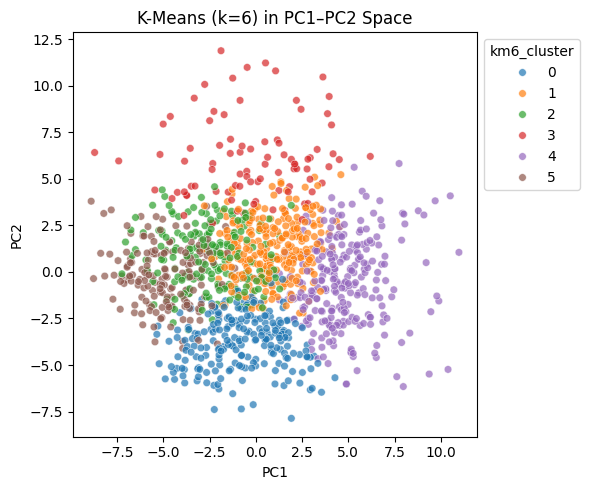

Saved model to: /Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/kmeans_model.joblib
Saved: /Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/cluster_summary.json


In [11]:
# K-Means Clustering

# make sure we have the PC matrix
X_cluster = df_pca[pc_cols].values
col = f'km{best_k}_cluster'

# Fit *fresh* at best_k
kmeans_best = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_best = kmeans_best.fit_predict(X_cluster)

# Attach labels to both dataframes
df_pca[col]   = labels_best
df_clean[col] = labels_best

# Silhouette for the chosen model
sil_best = silhouette_score(X_cluster, labels_best)
print(f"k={best_k}, silhouette = {sil_best:.3f}")

# Basic centroids on key stats (optional)
key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']
cent = (
    df_clean.groupby(col)[key_stats]
    .mean()
    .round(2)
    .rename_axis('cluster')
)
print("Centroids:")
print(cent.to_string())

# Scatter in PC1–PC2 (use the correct labels)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_pca['PC1'].values,
    y=df_pca['PC2'].values,
    hue=labels_best,                 # <-- use labels_best
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title(f"K-Means (k={best_k}) in PC1–PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=col, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(kmeans_best, PATHS["model_file"])
print("Saved model to:", PATHS["model_file"])

# Save a concise summary JSON
summary = load_json(PATHS["cluster_summary"], default={})
summary.update({
    "selected": {
        "n_clusters": int(best_k),
        "pca_components": int(load_json(PATHS["selection"]).get("n_pca", 0))
    },
    "scores": {
        "silhouette": float(sil_best)
    },
    "cluster_sizes": {str(i): int((labels_best == i).sum())
                      for i in np.unique(labels_best)}
})
save_json(summary, PATHS["cluster_summary"])
print("Saved:", PATHS["cluster_summary"])


**ARCHETYPE MATCHING**

In [12]:
# Load basketball archetypes from JSON file
def load_archetypes_from_json(path="archetypes.json", strict=False):
    """
    Load archetypes from JSON into a dict[str, list[(metric, sign)]].
    - Strips whitespace from metric names (fixes typos like 'three_per100 ').
    - Coerces `sign` to int and checks it is in {-1, 1}.
    - If strict=True, raises on problems; else collects warnings.
    """
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    loaded = {}
    warnings = []

    for name, pairs in raw.items():
        cleaned_pairs = []
        for i, pair in enumerate(pairs):
            if not isinstance(pair, (list, tuple)) or len(pair) != 2:
                msg = f"[{name}] pair {i} is not [metric, sign]: {pair}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                continue

            metric = str(pair[0]).strip()
            try:
                sign = int(pair[1])
            except Exception:
                msg = f"[{name}] sign not int for metric '{metric}': {pair[1]}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                continue

            if sign not in (-1, 1):
                msg = f"[{name}] sign must be -1 or 1 for metric '{metric}', got {sign}"
                if strict:
                    raise ValueError(msg)
                warnings.append(msg)
                # clamp to nearest valid
                sign = 1 if sign > 0 else -1

            cleaned_pairs.append((metric, sign))
        loaded[name] = cleaned_pairs

    if warnings:
        print("Warnings while loading archetypes:")
        for w in warnings:
            print(" -", w)
    print(f"Loaded {len(loaded)} archetypes from {path}")
    return loaded

# Load from disk -> Python dict with tuples
archetypes = load_archetypes_from_json("../data/archetypes.json")


Loaded 50 archetypes from ../data/archetypes.json


In [13]:
cluster_col   = f'km{best_k}_cluster'
cluster_labels = np.sort(df_clean[cluster_col].unique())

# Collect the metrics we actually need and z-score them (vectorized)
all_metrics = sorted({m for lst in archetypes.values() for (m, _) in lst})
present_metrics = [m for m in all_metrics if m in df_clean.columns]

X = df_clean[present_metrics].astype(float).copy()
col_means = X.mean(axis=0, skipna=True)
X = X.fillna(col_means)
col_stds = X.std(axis=0, ddof=0).replace(0.0, 1.0)  # avoid div-by-zero
Z = (X - col_means) / col_stds  # global z-score

# Cluster centroids (mean z-score per metric)
# Use the series version of groupby to avoid adding cluster column to Z
cluster_centroids = Z.groupby(df_clean[cluster_col]).mean()   # shape: (n_clusters, n_metrics)
cluster_centroids = cluster_centroids.reindex(index=cluster_labels)

# Build a rectangular score matrix for all clusters × all archetypes (vectorized)
def archetype_weights(n, base=0.5):
    # decreasing geometric weights from most-important → least-important
    raw = np.array([base**i for i in range(n)][::-1], dtype=float)
    return raw / raw.sum()

arch_names = list(archetypes.keys())
score_matrix = np.full((len(cluster_labels), len(arch_names)), -1e3, dtype=float)  # default if no overlap

metrics_cols = cluster_centroids.columns

for j, arch in enumerate(arch_names):
    feats = [m for m, _ in archetypes[arch] if m in metrics_cols]
    if not feats:
        continue
    # indices in the archetype's list that actually exist
    idxs_in_arch = [i for i, (m, _) in enumerate(archetypes[arch]) if m in metrics_cols]
    # weight mask (renormalized over present features)
    w_full = archetype_weights(len(archetypes[arch]))
    w = w_full[idxs_in_arch]
    w = w / w.sum()

    # signs aligned to feats
    signs = np.array([s for (m, s) in archetypes[arch] if m in metrics_cols], dtype=float)
    # Z-scores for all clusters over these feats
    C = cluster_centroids.loc[:, feats].to_numpy()  # shape: (n_clusters, len(feats))
    # weighted sum per cluster
    # multiply by sign (direction) then dot with weights
    scores = (C * signs) @ w
    score_matrix[:, j] = scores

# Solve one rectangular assignment: each cluster maps to a unique archetype
# We want to maximize score, so minimize negative score
cost = -score_matrix
row_ind, col_ind = linear_sum_assignment(cost)  # works with rectangular matrices

best_mapping = {int(cluster_labels[r]): arch_names[c] for r, c in zip(row_ind, col_ind)}
best_total   = score_matrix[row_ind, col_ind].sum()

print("Best total score:", best_total)
print("Cluster -> Archetype")
for cl in cluster_labels:
    arch = best_mapping.get(int(cl), None)
    print(f"{cl}: {arch}")

# Report confidence (row-wise margin between best and second-best)
row_best = score_matrix.max(axis=1)
row_second = np.partition(score_matrix, -2, axis=1)[:, -2]
confidence = {int(cluster_labels[i]): float(row_best[i] - row_second[i]) for i in range(len(cluster_labels))}

print("\nConfidence margins:")
for cl in cluster_labels:
    print(f"{cl}: {confidence[int(cl)]:.3f}")


Best total score: 6.283282834387486
Cluster -> Archetype
0: Putback Specialist
1: Deep Range Specialist
2: Non-Impact Role Player
3: Two-Way Guard
4: Rim Protector / Rebounding Big
5: Floor General

Confidence margins:
0: 0.178
1: 0.299
2: 0.810
3: 0.680
4: 0.030
5: 0.209


In [14]:
# Scoring Sytem 0-100%
score_df = pd.DataFrame(score_matrix, index=cluster_labels, columns=arch_names)

row_labels = list(score_df.index)
col_labels = list(score_df.columns)

assigned = []
cluster_map=dict()
for cl in row_labels:
    icl = int(cl)
    arch = best_mapping.get(icl)
    if arch is None:
        # belt-and-braces fallback if something slipped through
        j = int(np.nanargmax(score_df.loc[cl].values))
        arch = col_labels[j]
        best_mapping[icl] = arch
    raw = float(score_df.loc[cl, arch])
    pct = float(np.clip(raw, 0.0, 1.0)) * 100.0
    assigned.append({
        "cluster":   icl,
        "archetype": arch,
        "raw_score": raw,
        "match_%":   f"{pct:.1f}%"
    })
    cluster_map[icl] = arch

print("\nCluster -> Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))

# Update Cluster Summary
# Load the saved summary JSON
summary = load_json(PATHS["cluster_summary"], default={})

# Replace cluster numbers in "cluster_sizes" with archetype names
if "cluster_sizes" in summary:
    summary["cluster_sizes"] = {
        cluster_map.get(int(k), f"Cluster {k}"): v
        for k, v in summary["cluster_sizes"].items()
    }

# Save updated summary
save_json(summary, PATHS["cluster_summary"])
print("Updated with archetypes:", PATHS["cluster_summary"])



Cluster -> Archetype (with match % of a perfect 1σ fit):


,cluster,archetype,raw_score,match_%
0,0,Putback Specialist,1.099180,100.0%
1,1,Deep Range Specialist,0.855033,85.5%
2,2,Non-Impact Role Player,1.018988,100.0%
3,3,Two-Way Guard,1.369078,100.0%
4,4,Rim Protector / Rebounding Big,1.069220,100.0%
5,5,Floor General,0.871784,87.2%


Updated with archetypes: /Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_170916/cluster_summary.json


In [15]:
# Add human-readable archetype per player
cluster_col = "cluster" if "cluster" in df_clean.columns else f"km{int(best_k)}_cluster"
df_clean["Archetype"] = (
    df_clean[cluster_col].astype(int).map(best_mapping).fillna(df_clean[cluster_col].astype(str))
)
df_clean["cluster"] = df_clean[cluster_col].astype(int)  # ensure generic cluster column exists
df_clean["Archetype"] = df_clean["cluster"].map(best_mapping).fillna(df_clean["cluster"].astype(str))

# Sample output
print("\nSample players with archetypes:")
display(
    df_clean[["player_ind", "season", "cluster", "Archetype"]]
    .head(10)
)

# df_clean.drop(columns=["km6_cluster",'cluster'], inplace=True)

# merge archetype onto df_full by season-specific player_id
df_out=df_full.copy()
df_out["player_id"] = df_out["player_id"].astype(int)
df_clean["player_id"] = df_clean["player_id"].astype(int)

# ensure player_id types match
df_out['player_id'] = df_out['player_id'].astype(df_clean['player_id'].dtype)

# build a lookup: player_id -> Archetype
archetype_lookup = (
    df_clean.drop_duplicates('player_id')     # just in case
            .set_index('player_id')['Archetype']
)

# copy over; players not in df_clean get "Unknown"
df_out['Archetype'] = df_out['player_id'].map(archetype_lookup).fillna('Unknown')


df_out.to_parquet(PATHS["processed_data"])


Sample players with archetypes:


,player_ind,season,cluster,Archetype
0,Toby,2024-25,4,Rim Protector / Rebounding Big
1,Ashlon,2024-25,1,Deep Range Specialist
2,Oluchi,2024-25,4,Rim Protector / Rebounding Big
3,Reigan,2024-25,1,Deep Range Specialist
4,Delaney,2024-25,4,Rim Protector / Rebounding Big
5,Taina,2024-25,3,Two-Way Guard
6,Jadyn,2024-25,4,Rim Protector / Rebounding Big
7,Jordan,2024-25,0,Putback Specialist
8,Vanessa,2024-25,3,Two-Way Guard
9,Kayla Grimme,2017-18,4,Rim Protector / Rebounding Big
